# Assignment 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import distributions as iid
from scipy.stats import uniform,f,t,norm,chi2
from scipy.optimize import minimize
from scipy.special import factorial2
from scipy.stats import kstest

from tqdm import tqdm

from GMM_class import GMM

## Question 1

##### (1)
(1) **Describe the Parameter Space $B$**: Define the set of parameters that we need to estimate. The space $B$ represents all the possible value of parameters.</br>
(2) **Describe function $g_i(\beta)$**: With analogy principle, turn each moment condition $Eg_i(\beta)=0$ into $g_N(b)=\frac{1}{N}\sum g_i(b)=0$, here $\beta$ is true value while $b$ is our estimate value.</br>
(3) **Describe covariance matrix**: to construct an optimally weighted GMM estimator of $\beta$, we need to estimate the convariance matrix of the moment conditions in (2) as a weight. It follows that $\Omega=Eg_i(\beta)g_i(\beta)'$. However, since it might be over identified ($l>k$), our estimator in practise would be $\hat{\Omega}=Eg_i(b)g_i(b)'-Eg_i(b)Eg_i(b)'$.</br>
(4) **Optimally weighted GMM estimator**: follow the previous steps, we turn the question into an optimization problem which follows $b=argmin\ Ng_N(b)'Ag_N(b)$, while $A$ is the weight here. From (3) we know that we need $b$ to estimate the convariance matrix, hence we could use $I$ to identify $b$ first and calculate $\hat{\Omega}$, then use $\hat{\Omega}^{-1}$ as the weight in the estimator.

##### (2)&(3)

(a) Unknown parameters: $\mu$,$\sigma$</br>
Estimating equations:
$$
E[y-\mu]=0\\
E[(y-\mu)^2-\sigma^2]=0\\
E[(y-\mu)^3]=0
$$
Since it's just identified, we could use $\hat{\Omega}=Eg_i(b)g_i(b)'$

In [6]:
def dgp_a(n,mu,sigma):
    return iid.norm(mu,sigma).rvs(n)

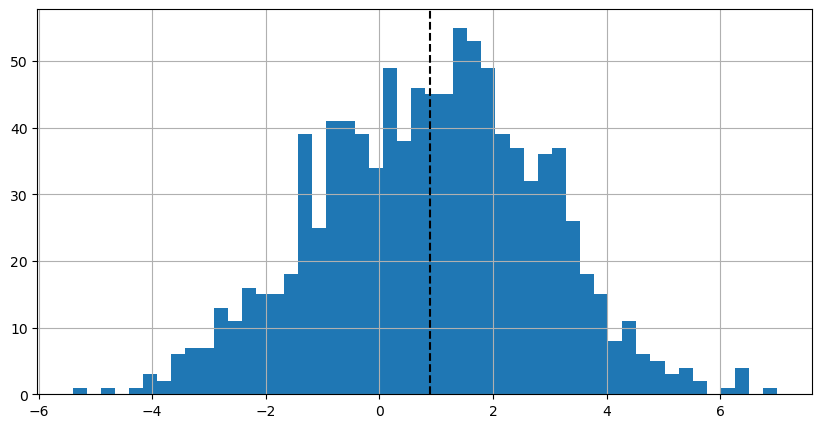

In [14]:
# true value
n = 1000
mu = 1
sigma = 2

# dgp
y = dgp_a(n,mu,sigma)

# plot
fig,ax = plt.subplots(figsize=(10,5))
ax.hist(y,bins=50)
ax.axvline(y.mean(),linestyle='--',c='black')
ax.grid()
plt.show()

(b) Unknown parameters: $\alpha$,$\beta$</br>
Estimating equations:
$$
E[X'(y-\alpha-X\beta)]=0\\
E[y-\alpha-X\beta]=0
$$
Since it's just identified, we could use $\hat{\Omega}=Eg_i(b)g_i(b)'$

In [23]:
def dgp_b(n,alpha,beta,mu_x,sigma_x,sigma_u):
    u = iid.norm(0,sigma_u).rvs(n)
    x = iid.norm(mu_x,sigma_x).rvs(n)
    y = alpha+beta*x+u
    
    x = pd.DataFrame({'constant':1,
                      'x':x})
    return y,x

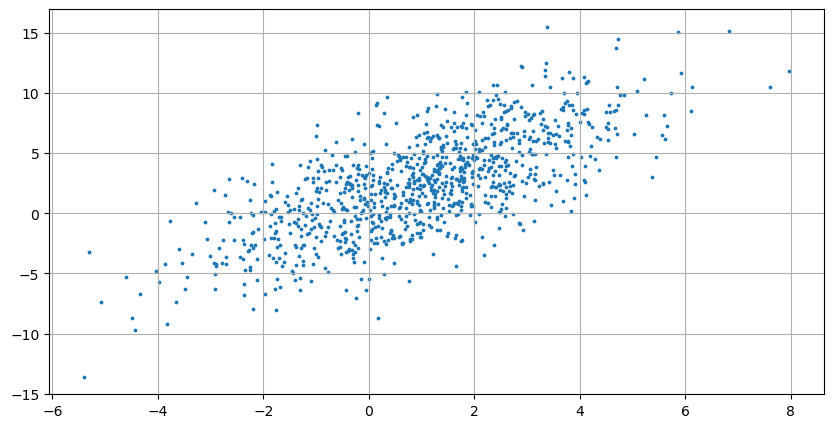

In [22]:
# true value
n = 1000
alpha = 1
beta = 1.5
mu_x = 1
sigma_x = 2
sigma_u = 3

# dgp
y,x = dgp_b(n,alpha,beta,mu_x,sigma_x,sigma_u)

# plot
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(x['x'],y,s=3)
ax.grid()
plt.show()

(c) Unknown parameters: $\alpha$, $\beta$, $\sigma$</br>
Estimating equations:
$$
E[X'(y-\alpha-X\beta)]=0\\
E[y-\alpha-X\beta]=0\\
E[(y-\alpha-X\beta)^2-\sigma^2]=0
$$
The data generation is exactly the same as (b), while only the estimator is different. Since it's just identified, we could use $\hat{\Omega}=Eg_i(b)g_i(b)'$

(d) Unknown parameters: $\alpha$, $\beta$, $\sigma$</br>
Estimating equations:
$$
E[X'(y-\alpha-X\beta)]=0\\
E[y-\alpha-X\beta]=0\\
E[(y-\alpha-X\beta)^2-e^{X\sigma}]=0
$$
Since it's just identified, we could use $\hat{\Omega}=Eg_i(b)g_i(b)'$

In [38]:
def dgp_d(n,alpha,beta,mu_x,sigma_x,sigma_u):
    x = iid.norm(mu_x,sigma_x).rvs(n)
    u = np.exp(x*sigma_u)
    y = alpha+beta*x+u
    
    x = pd.DataFrame({'constant':1,
                      'x':x})
    return y,x

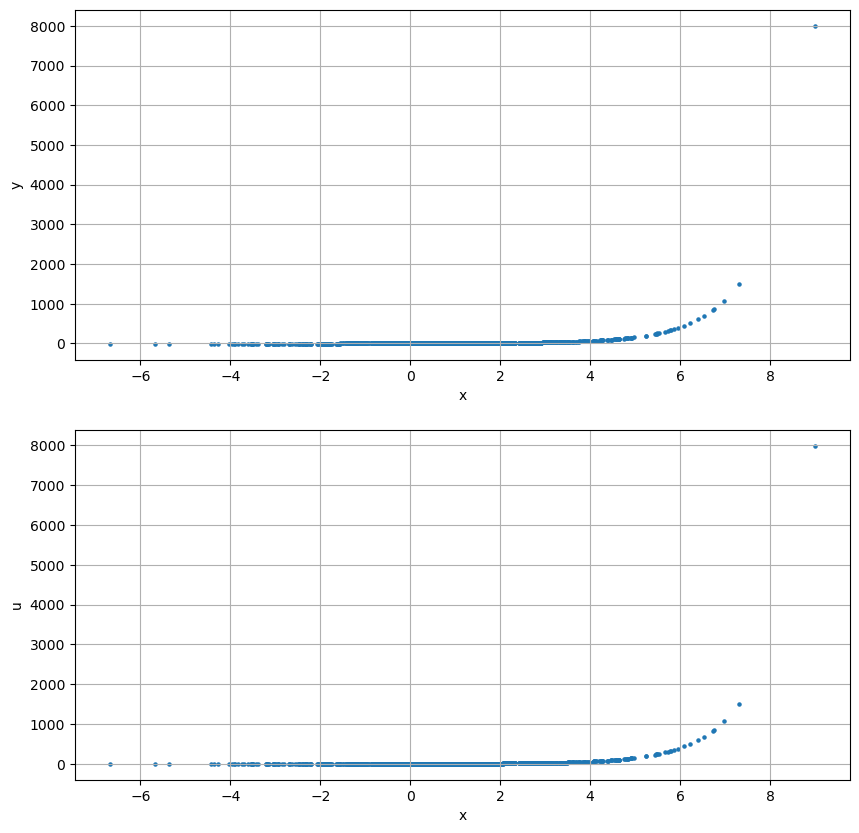

In [44]:
# true value
n = 1000
alpha = 1
beta = 1.5
mu_x = 1
sigma_x = 2
sigma_u = 1

# dgp
y,x = dgp_d(n,alpha,beta,mu_x,sigma_x,sigma_u)

# plot
fig,ax = plt.subplots(2,1,figsize=(10,10))

ax[0].scatter(x['x'],y,s=5)
ax[0].grid()
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(x['x'],y-x@[alpha,beta],s=5)
ax[1].grid()
ax[1].set_xlabel('x')
ax[1].set_ylabel('u')

plt.show()

(e) Unknown parameters: $\alpha$, $\beta$</br>
Estimating equations:
$$
E[Z'(y-\alpha-X\beta)]=0\\
E[y-\alpha-X\beta]=0
$$
If the dimision of Z is 1, then since it's just identified, we could use $\hat{\Omega}=Eg_i(b)g_i(b)'$. Otherwise, we need to use $\hat{\Omega}=Eg_i(b)g_i(b)'-Eg_i(b)Eg_i(b)'$

In [69]:
def dgp_e(n,alpha,beta,sigma_u,gamma,VXZ):
    u = iid.norm(0,sigma_u).rvs(n)
    
    # get the square root of VXZ
    val_xz, vec_xz = np.linalg.eig(VXZ)
    SXZ = vec_xz@np.diag(np.sqrt(val_xz))
    
    XZ = iid.norm.rvs(size=(n,SXZ.shape[0]))@SXZ
    x = XZ[:,0]+gamma*u # endogenous
    Z = XZ[:,1:]
    
    y = alpha+beta*x+u
    x = pd.DataFrame({'constant':1,
                      'x':x})
    return y,x,Z

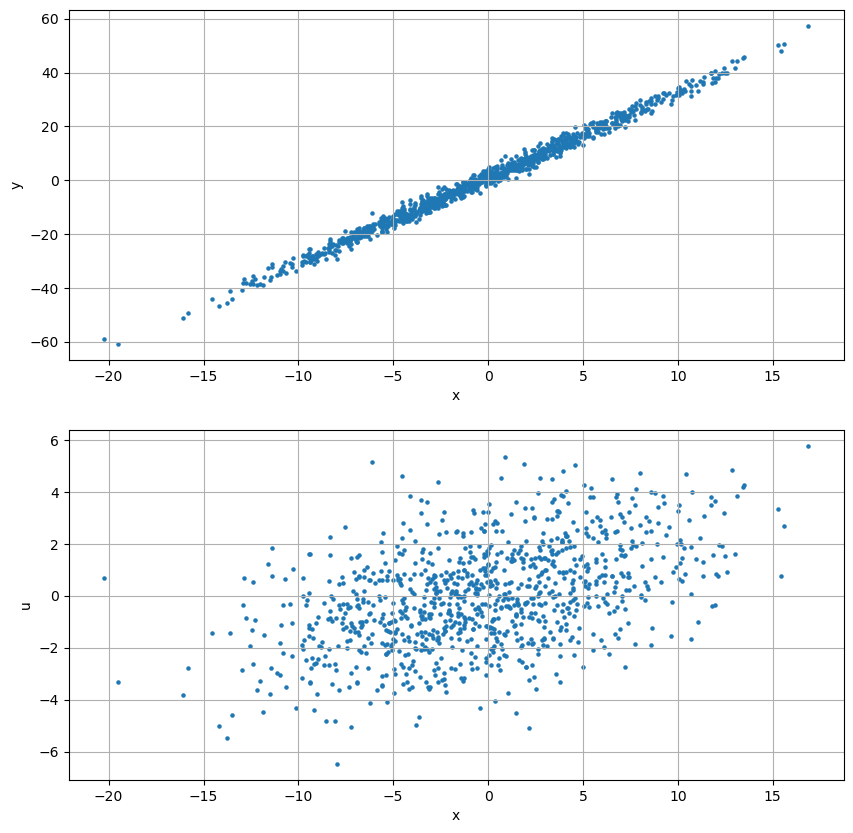

In [71]:
# true value
n = 1000
alpha = 1
beta = 3
sigma_u = 2
gamma = 1.5
l = 4
SXZ = np.sqrt(iid.uniform(0,2).rvs((l+1)**2)).reshape((l+1,l+1))
VXZ = SXZ.T@SXZ

y,x,Z = dgp_e(n,alpha,beta,sigma_u,gamma,VXZ)

# plot
fig,ax = plt.subplots(2,1,figsize=(10,10))

ax[0].scatter(x['x'],y,s=5)
ax[0].grid()
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(x['x'],y-x@[alpha,beta],s=5)
ax[1].grid()
ax[1].set_xlabel('x')
ax[1].set_ylabel('u')

plt.show()

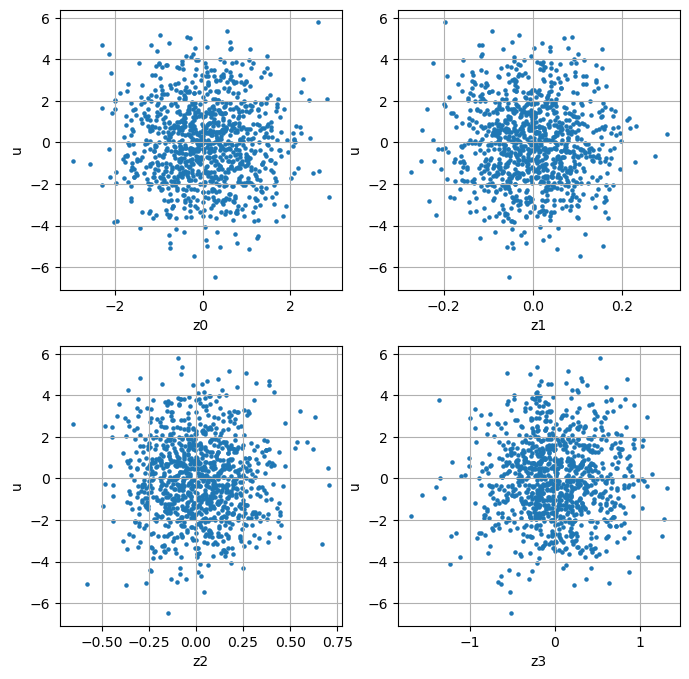

In [72]:
# plot Z and u
fig, ax = plt.subplots(2,2,figsize=(8,8))
for i in range(4):
    row = i//2
    col = i%2
    ax[row,col].scatter(Z[:,[i]],y-x@[alpha,beta],s=5)
    ax[row,col].grid()
    ax[row,col].set_xlabel('z'+str(i))
    ax[row,col].set_ylabel('u')
plt.show()

(f) Unknown paramters: $\beta$</br>
Estimating equations:
$$
E[Z'(y-f(X\beta))]=0\\
E[y-f(X\beta)]=0
$$
Since it's over-identified, we need to use $\hat{\Omega}=Eg_i(b)g_i(b)'-Eg_i(b)Eg_i(b)'$</br>
The last restriction is from
$$
\frac{\partial E[Z'(y-f(X\beta))]}{\partial \beta'}=E[Z'Xf'(X\beta)]=Q(\beta)
$$
It would be used in the asymptotic variance of our estimated $\beta$, its role is to ensure the matrix exists, which would allow us to calculate the asymptotic variance and do the hypothesis test.

In [84]:
def dgp_f(n,beta,f,sigma_u,gamma,VXZ):
    u = iid.norm(0,sigma_u).rvs(n)
    
    # get the square root of VXZ
    val_xz, vec_xz = np.linalg.eig(VXZ)
    SXZ = vec_xz@np.diag(np.sqrt(val_xz))
    
    XZ = iid.norm.rvs(size=(n,SXZ.shape[0]))@SXZ
    x = XZ[:,0]+gamma*u # endogenous
    Z = XZ[:,1:]
    
    y = f(beta*x)+u
    x = pd.DataFrame({'constant':1,
                      'x':x})
    return y,x,Z

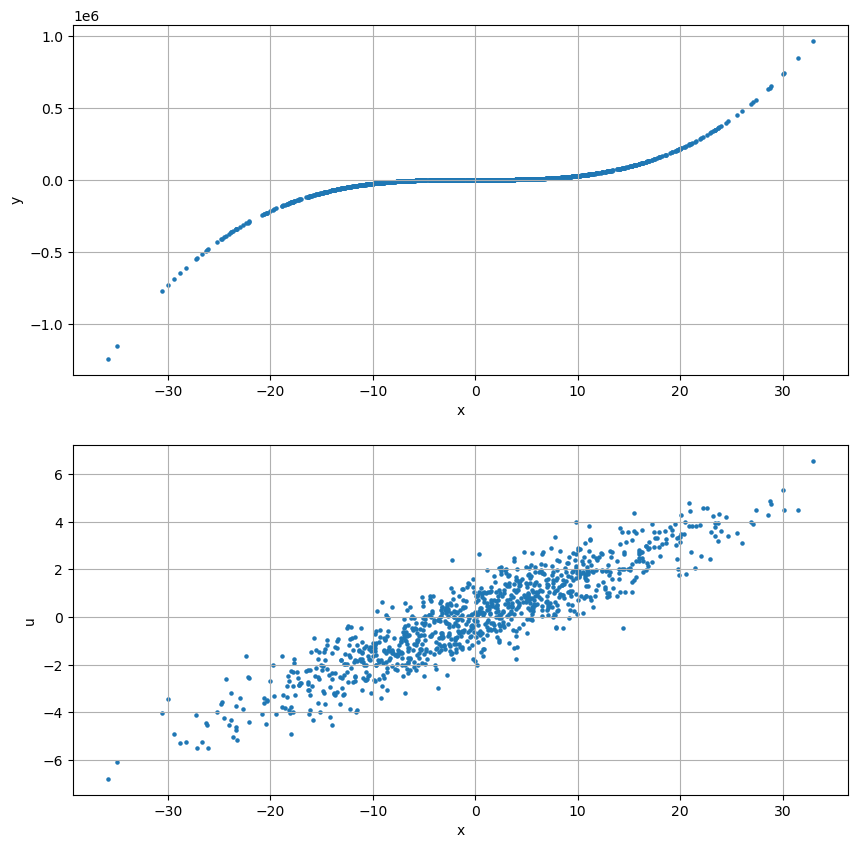

In [86]:
# true value
n = 1000
beta = 3
f = lambda x:x**3
sigma_u = 2
gamma = 5
l = 4
SXZ = np.sqrt(iid.uniform(0,2).rvs((l+1)**2)).reshape((l+1,l+1))
VXZ = SXZ.T@SXZ

y,x,Z = dgp_f(n,beta,f,sigma_u,gamma,VXZ)

# plot
fig,ax = plt.subplots(2,1,figsize=(10,10))

ax[0].scatter(x['x'],y,s=5)
ax[0].grid()
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(x['x'],y-f(beta*x['x']),s=5)
ax[1].grid()
ax[1].set_xlabel('x')
ax[1].set_ylabel('u')

plt.show()

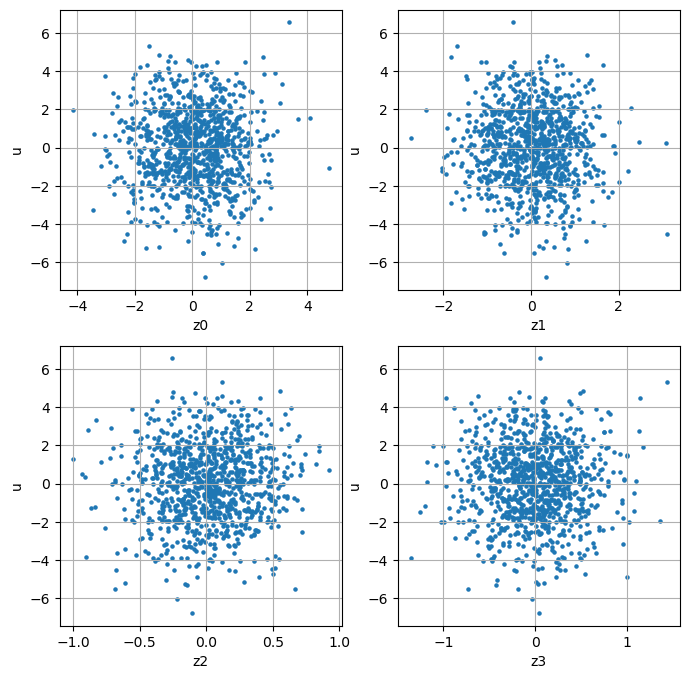

In [88]:
# plot Z and u
fig, ax = plt.subplots(2,l//2,figsize=(8,8))
for i in range(l):
    row = i//2
    col = i%2
    ax[row,col].scatter(Z[:,[i]],y-f(beta*x['x']),s=5)
    ax[row,col].grid()
    ax[row,col].set_xlabel('z'+str(i))
    ax[row,col].set_ylabel('u')
plt.show()

(g) Unknown paramters: $\beta$</br>
Estimating equations:
$$
E[Z'(y-f(X,\beta))]=0\\
E[y-f(X,\beta)]=0
$$
Since it's over-identified, we need to use $\hat{\Omega}=Eg_i(b)g_i(b)'-Eg_i(b)Eg_i(b)'$

In [89]:
def dgp_g(n,beta,f,sigma_u,gamma,VXZ):
    u = iid.norm(0,sigma_u).rvs(n)
    
    # get the square root of VXZ
    val_xz, vec_xz = np.linalg.eig(VXZ)
    SXZ = vec_xz@np.diag(np.sqrt(val_xz))
    
    XZ = iid.norm.rvs(size=(n,SXZ.shape[0]))@SXZ
    x = XZ[:,0]+gamma*u # endogenous
    Z = XZ[:,1:]
    
    y = f(x,beta)+u
    x = pd.DataFrame({'constant':1,
                      'x':x})
    return y,x,Z

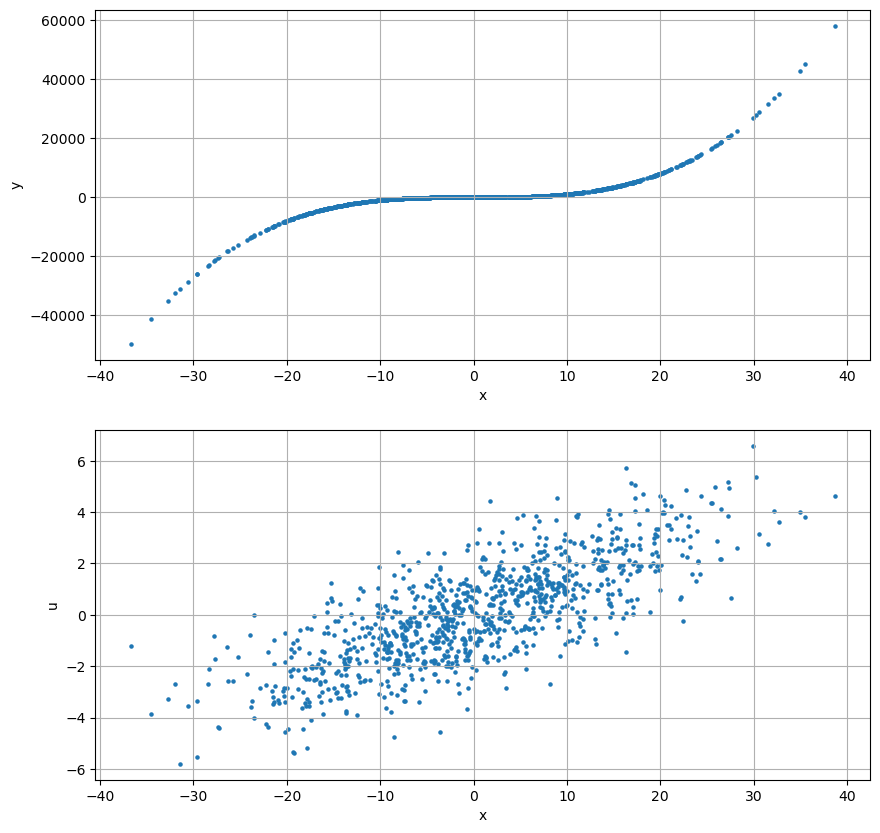

In [94]:
# true value
n = 1000
beta = 3
f = lambda x,b:x**(b)
sigma_u = 2
gamma = 5
l = 4
SXZ = np.sqrt(iid.uniform(1,2.5).rvs((l+1)**2)).reshape((l+1,l+1))
VXZ = SXZ.T@SXZ

y,x,Z = dgp_g(n,beta,f,sigma_u,gamma,VXZ)

# plot
fig,ax = plt.subplots(2,1,figsize=(10,10))

ax[0].scatter(x['x'],y,s=5)
ax[0].grid()
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(x['x'],y-f(x['x'],beta),s=5)
ax[1].grid()
ax[1].set_xlabel('x')
ax[1].set_ylabel('u')

plt.show()

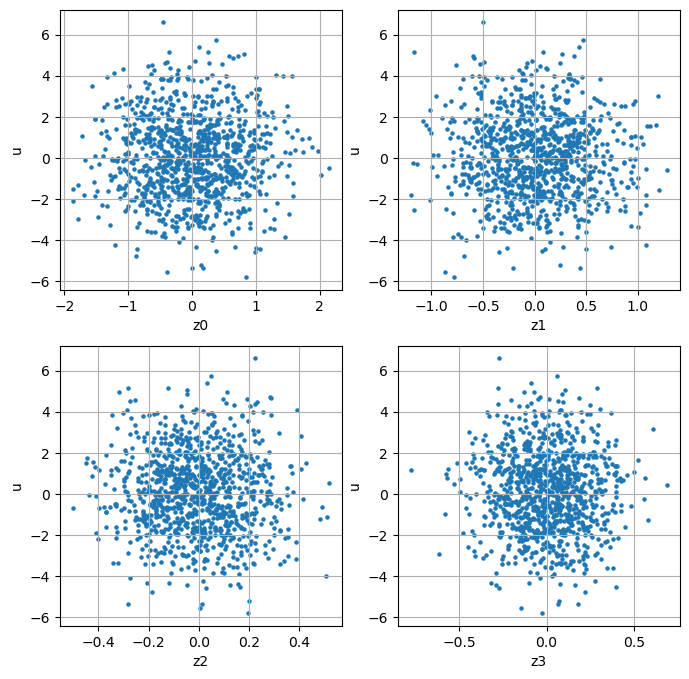

In [95]:
# plot Z and u
fig, ax = plt.subplots(2,l//2,figsize=(8,8))
for i in range(l):
    row = i//2
    col = i%2
    ax[row,col].scatter(Z[:,[i]],y-f(x['x'],beta),s=5)
    ax[row,col].grid()
    ax[row,col].set_xlabel('z'+str(i))
    ax[row,col].set_ylabel('u')
plt.show()

(h) Unknown paramters: $\alpha$, $\gamma$</br>
Estimating equations:
$$
E[Z'(y^\gamma-\alpha)]=0\\
E[y^\gamma-\alpha]=0
$$
If the dimision of Z is 1, then since it's just identified, we could use $\hat{\Omega}=Eg_i(b)g_i(b)'$. Otherwise, we need to use $\hat{\Omega}=Eg_i(b)g_i(b)'-Eg_i(b)Eg_i(b)'$

In [14]:
def dgp_h(n,alpha,gamma,sigma_u):
    u = iid.norm(0,sigma_u).rvs(n)
    y = pd.DataFrame(alpha+u).iloc[:,0].apply(lambda x:np.power(x,1/gamma) if x>0 else np.power(-1*x,1/gamma)*(-1))
    return y

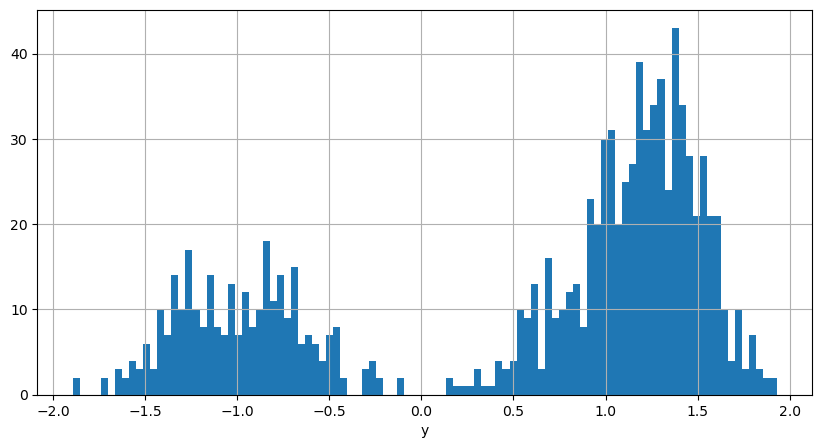

In [15]:
# true value
n = 1000
alpha = 1
gamma = 3
sigma_u = 2

y = dgp_h(n,alpha,gamma,sigma_u)

# plot
fig,ax = plt.subplots(figsize=(10,5))

ax.hist(y,bins=100)
ax.grid()
ax.set_xlabel('y')

plt.show()

##### （4）
We try to practice GMM_class with dgp in (d).

In [31]:
def dgp_d(n,alpha,beta,mu_x,sigma_x,sigma_u):
    x = iid.norm(mu_x,sigma_x).rvs(n)
    u = np.exp(x*sigma_u)
    y = alpha+beta*x+u
    
    x = pd.DataFrame({'constant':1,
                      'x':x})
    return y,x

# true value
n = 1000
alpha = 1
beta = 1.5
mu_x = 1
sigma_x = 2
sigma_u = 1

y,x = dgp_d(n,alpha,beta,mu_x,sigma_x,sigma_u)

In [58]:
def gj(b,data):
    y,x = data
    a,b,sigma = b
    n = x.shape[0]
    beta = np.array([[a],[b]])
    
    # estimating equations
    e1 = np.array(x)*(y.reshape(n,1)-np.array(x@beta))
    e2 = (y.reshape(n,1)-np.array(x@beta))*(y.reshape(n,1)-np.array(x@beta))-np.exp(x*sigma)
    e = np.concatenate((e1,e2),axis=1)
    return e

In [60]:
est = GMM(gj,(y,x),(1,1,1))

In [64]:
# one step
b1 = est.one_step_gmm()
print(b1)

(array([ 3.3081326 , 16.15986332,  1.93274527]), array(4.8510059e+09))


In [65]:
# two step
b2 = est.two_step_gmm()
print(b2)

[4.74593068 9.71425295 1.92871835]


## Question 3

##### (1) 
Since we couldn;t observe $u$, we couldn't test $E(ux)=Eu=0$ as well.
##### (2)
From the condition $E(u^2|x)=\sigma^2$, the conditional expectation of $u^2$ is a constant, which means it is not a function of x, and since then the coefficient of $x$ here should be 0 when we run the regression $\hat{u}^2 = c+dx+e$.

##### (3)
The data generation process is as follows,
$$
y=\alpha+\beta x+u\\
E(ux) = 0\\
E(u^2|x)=\sigma^2
$$


In [105]:
def dgp(n,alpha,beta,mu_x,sigma_x,sigma_u):
    x = iid.norm(mu_x,sigma_x).rvs(n)
    
    u = iid.norm(0,sigma_u).rvs(n)
    
    y = alpha+beta*x+u
    
    y = pd.DataFrame({'y':y})
    x = pd.DataFrame({'constant':1,'x':x})
    
    return y,x

Then we try to get the data and estimate the residuals.

In [106]:
# true value
n = 1000
alpha = 1
beta = 1.5
mu_x = 2
sigma_x = 1.5
sigma_u = 2

# dgp
y,x = dgp(n,alpha,beta,mu_x,sigma_x,sigma_u)

# ols
beta_hat = np.linalg.solve(x.T@x,x.T@y)

# residual
u = y-np.array(x@beta_hat)
su = u**2

Now we try to carry out the conventional Breusch-Pagan test.
$$
\hat{u}^2=c+dx+e\\
H_0: d=0
$$
Here we use t test to test the null hypothesis.

In [107]:
def bp(su,x):
    # regression
    gamma_hat = np.linalg.solve(x.T@x,x.T@su)
    d = gamma_hat[1]
    
    # test null hypothesis: d = 0
    e = np.array(su)-np.array(x@gamma_hat)
    n = x.shape[0]
    k = x.shape[1]
    ss = ((e.T@e)/n)[0]
    Q = np.diag(x.T@x)[1]

    tvalue = d/np.sqrt(ss/Q)
    
    # p value
    pvalue = min(1-t.cdf(tvalue,n-k),t.cdf(tvalue,n-k))*2
    
    res = pd.DataFrame({'d':d,
                        'std':np.sqrt(ss/Q),
                        'tvalue':tvalue,
                        'pvalue':pvalue})
    
    return res

In [108]:
bp_res = bp(su,x)
print(bp_res)

          d       std    tvalue    pvalue
0 -0.114376  0.069399 -1.648093  0.099648


Now we try to construct a GMM version of Breusch-Pagan test as follows:</br>
(1) estimate $\hat{u}^2$ from $y=\alpha+\beta x+u$</br>
(2) from $\hat{u}^2=c+dx+e$, since for a linear regression we have the following assumption,
$$
(a.i)E[xe]=E[e]=0\\
(a.ii)E[e^2|x]=\sigma^2
$$
Then we could construct three estimating equations,
$$
E[xe]=E[x(\hat{u}^2-c-dx)]=0\\
E[e]=E[\hat{u}^2-c-dx]=0\\
E[e^2-\sigma^2]=E[(\hat{u}^2-c-dx)^2-\sigma^2]=0
$$

In the GMM version of BP test, there are three equations and three parameters.

In [109]:
def gj(c,d,ssigma,su,x):
    n = x.shape[0]
    gamma = np.array([[c],[d]])
    
    # estimating equations
    e1 = np.array(x)*(np.array(su)-np.array(x@gamma))
    e2 = (np.array(su)-np.array(x@gamma))*(np.array(su)-np.array(x@gamma))-ssigma
    e = np.concatenate((e1,e2),axis=1) # value of gj
    return e

def Omega(params,su,x,gj):
    c = params[0]
    d = params[1]
    ssigma = params[2]
    
    n = x.shape[0]
    e = gj(c,d,ssigma,su,x)
    # Omega hat
    Omega_hat = (e - e.mean(axis=0)).T@(e - e.mean(axis=0))/n
    return Omega_hat
    
def J(params,su,x,W,gj):
    c = params[0]
    d = params[1]
    ssigma = params[2]
    
    n = x.shape[0]
    e = gj(c,d,ssigma,su,x)
    # J
    Jvalue = n*e.mean(axis=0).T@W@e.mean(axis=0)
    #e1 = np.array(x.T)@(np.array(su)-np.array(x@gamma))/n
    #e2 = (np.array(su)-np.array(x@gamma)).T@(np.array(su)-np.array(x@gamma))/n-ssigma
    #e = np.concatenate((e1,e2))
    return Jvalue

def Q(params,su,x):
    x = np.array(x)
    su = np.array(su)
    
    n = x.shape[0]
    
    c = params[0]
    d = params[1]
    ssigma = params[2]
    e = su-x@np.array([[c],[d]])
    
    
    Q_hat = np.array([[1,            x[:,1].mean(),            0],
                      [x[:,1].mean(),x[:,1].T@x[:,1]/n,        0],
                      [2*e.mean(),   (2*(e.T@(d*x[:,1]))/n)[0],1]])
    return Q_hat

Now, since we need to do hypothesis test, we need to know $Q=\frac{\partial{g_N(\beta)}}{\partial{\beta'}}$, and through matrix calculus we'll get
$$
Q = 
 \left[
 \begin{matrix}
   1 & \frac{1}{N}\sum{x_i} & 0 \\
   \frac{1}{N}\sum{x_i} & \frac{1}{N}\sum{x_i^2} & 0 \\
   \frac{1}{N}\sum{2(\hat{u}^2-c-dx)} & \frac{1}{N}\sum{2(\hat{u}^2-c-dx)dx_i} & 1
  \end{matrix}
  \right] \tag{3}
$$


In [110]:
def bp_gmm(su,x,gj,Q):
    # first step
    W1 = np.eye(gj(1,1,1,su,x).shape[1]) # identity matrix
    param_hat1 = minimize(lambda params:J(params,su,x,W1,gj),x0=[1,0,1]).x
    
    # second step
    W2 = np.linalg.inv(Omega(param_hat1,su,x,gj))
    res = minimize(lambda params:J(params,su,x,W2,gj),x0=[1,0,1])
    
    param_hat2 = res.x
    
    n = x.shape[0]
    c = param_hat2[0]
    d = param_hat2[1]
    ssigma = param_hat2[2]
    e = su-x@np.array([[c],[d]])
    
    # asympothe variance
    Q_hat = Q(param_hat2,su,x)
    avar = np.linalg.inv(Q_hat.T@W2@Q_hat)
    
    # bp test
    tvalue = d/np.sqrt(np.diag(avar/n)[1])
    pvalue = min(1-norm.cdf(tvalue),norm.cdf(tvalue))*2
    
    # result
    res = pd.DataFrame({'d':d,
                        'std':np.sqrt(np.diag(avar/n)[1]),
                        'tvalue':tvalue,
                        'pvalue':pvalue},index=[0])
    return res

In [111]:
bp_gmm_res = bp_gmm(su,x,gj,Q)
print(bp_gmm_res)

          d       std    tvalue    pvalue
0 -0.114376  0.110042 -1.039381  0.298627


##### (4)
First we do the Monte Carlo stimulation seperately.

In [10]:
# true value
n = 1000
alpha = 1
beta = 1.5
mu_x = 2
sigma_x = 1.5
sigma_u = 2

M = 1000 # Monte Carlo draws

bp_draws = pd.DataFrame()
bp_gmm_draws = pd.DataFrame()

for i in tqdm(range(M)):
    # dgp
    y,x = dgp(n,alpha,beta,mu_x,sigma_x,sigma_u)
    
    # ols
    beta_hat = np.linalg.solve(x.T@x,x.T@y)

    # residual
    u = y-np.array(x@beta_hat)
    su = u**2
    
    bp_draws = pd.concat([bp_draws,bp(su,x)])
    bp_gmm_draws = pd.concat([bp_gmm_draws,bp_gmm(su,x,gj,Q)])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:50<00:00,  5.87it/s]


First we try to visualize the bias.

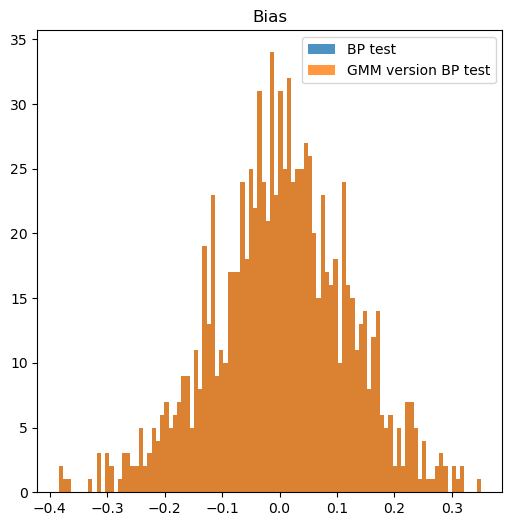

In [11]:
# visualize
fig,ax = plt.subplots(figsize=(6,6))

ax.hist(bp_draws['d'],label='BP test',bins=100,alpha=0.8)
ax.hist(bp_gmm_draws['d'],label='GMM version BP test',bins=100,alpha=0.8)
ax.legend()
ax.set_title('Bias')
plt.show()

Then we try to see other properties.

In [12]:
print('Precision of BP test:{:.4f}'.format(bp_draws['std'].mean()))
print('Precision of BP GMM test:{:.4f}'.format(bp_gmm_draws['std'].mean()))

print('Type one error of BP test:{:.4f}'.format((bp_draws['pvalue']<0.05).mean()))
print('Type one error of BP GMM test:{:.4f}'.format((bp_gmm_draws['pvalue']<0.05).mean()))

Precision of BP test:0.0711
Precision of BP GMM test:0.1180
Type one error of BP test:0.2380
Type one error of BP GMM test:0.0560


Last let's see the distribution.

In [13]:
# theoretical distribution
theory_bp = iid.norm(0,bp_res['std'])
theory_bp_gmm = iid.norm(0,bp_gmm_res['std'])

In [14]:
# pp plot
def ppplot(data,dist,title):
    data = np.array(data['d'])

    # Theoretical CDF, evaluated at points of data
    P = [dist.cdf(x) for x in data.tolist()]

    # Empirical CDF, evaluated at points of data
    Phat = [(data<x).mean() for x in data.tolist()]

    fig, ax = plt.subplots()

    ax.scatter(P,Phat)
    ax.plot([0,1],[0,1],color='r') # Plot 45
    ax.set_xlabel('Theoretical Distribution')
    ax.set_ylabel('Empirical Distribution')
    ax.set_title(title)
    plt.show()

    return 

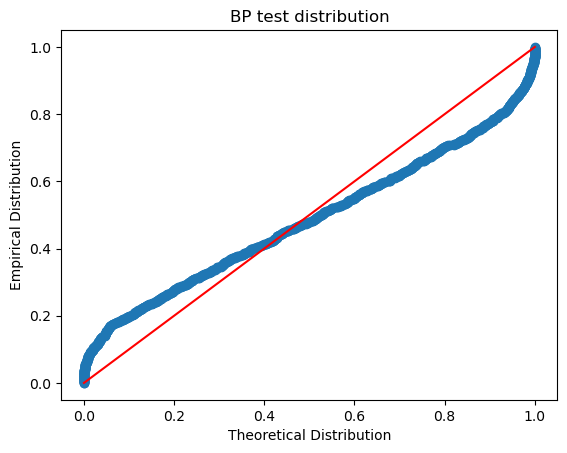

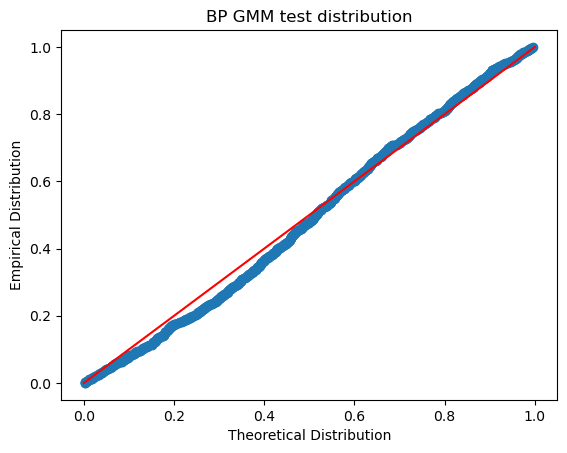

In [15]:
ppplot(bp_draws,theory_bp,'BP test distribution')
ppplot(bp_gmm_draws,theory_bp_gmm,'BP GMM test distribution')

From results above, we could see that</br>
Conventional BP test have higher precision,</br>
GMM version BP test have less type one error and needs less sample to get its asympothe properties.

##### (5)

First let's redefine the data genetation process.

In [118]:
def dgp_sin(n,alpha,beta,loc_x,scale_x,sigma_x,sigma_u):
    x = iid.uniform(loc_x,scale_x).rvs(n)

    u = iid.norm(0,sigma_u).rvs(n)*np.sqrt(np.abs(np.sin(2*x)))
    
    y = alpha+beta*x+u
    
    y = pd.DataFrame({'y':y})
    x = pd.DataFrame({'constant':1,'x':x})
    
    return y,x

In [119]:
# true value
n = 1000
alpha = 1
beta = 1.5
loc_x = 0
scale_x = 2*np.pi
sigma_x = 1.5
sigma_u = 2

# dgp
y,x = dgp_sin(n,alpha,beta,loc_x,scale_x,sigma_x,sigma_u)

# ols
beta_hat = np.linalg.solve(x.T@x,x.T@y)

# residual
u = y-np.array(x@beta_hat)
su = u**2

Now lets see the result of conventional bp test and gmm bp test.

In [120]:
bp_res = bp(su,x)
print(bp_res)

          d       std    tvalue    pvalue
0  0.112328  0.037473  2.997535  0.002789


In [121]:
bp_gmm_res = bp_gmm(su,x,gj,Q)
print(bp_gmm_res)

          d       std    tvalue   pvalue
0  0.112328  0.076085  1.476351  0.13985


We could see that both of them could not reject the false null hypothesis.</br>
Then we try to do the Monte Carlo stimulation.

In [122]:
# true value
n = 1000
alpha = 1
beta = 1.5
loc_x = 0
scale_x = 2*np.pi
sigma_x = 1.5
sigma_u = 2

M = 1000 # Monte Carlo draws

bp_draws = pd.DataFrame()
bp_gmm_draws = pd.DataFrame()

for i in tqdm(range(M)):
    # dgp
    y,x = dgp_sin(n,alpha,beta,loc_x,scale_x,sigma_x,sigma_u)
    
    # ols
    beta_hat = np.linalg.solve(x.T@x,x.T@y)

    # residual
    u = y-np.array(x@beta_hat)
    su = u**2
    
    bp_draws = pd.concat([bp_draws,bp(su,x)])
    bp_gmm_draws = pd.concat([bp_gmm_draws,bp_gmm(su,x,gj,Q)])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:20<00:00,  4.99it/s]


In [123]:
print('Bias of BP test:{:.4f}'.format(bp_draws['d'].mean()-sigma_u**2))
print('Bias of BP GMM test:{:.4f}'.format(bp_gmm_draws['d'].mean()-sigma_u**2))

print('Precision of BP test:{:.4f}'.format(bp_draws['std'].mean()))
print('Precision of BP GMM test:{:.4f}'.format(bp_gmm_draws['std'].mean()))

print('Type two error of BP test:{:.4f}'.format((bp_draws['pvalue']>0.05).mean()))
print('Type two error of BP GMM test:{:.4f}'.format((bp_gmm_draws['pvalue']>0.05).mean()))

Bias of BP test:0.0017
Bias of BP GMM test:0.0017
Precision of BP test:0.0365
Precision of BP GMM test:0.0715
Type two error of BP test:0.6760
Type two error of BP GMM test:0.9550


We could see BP test has about 70% to get an type two error, and GMM version performs even worse since its asympothe variance is larger.</br>
However, since we know the function form of the heteroskedastic disturbance, we could modify our GMM version test by changing the estimating equations. We first change the auxiliary regression into $uˆ2 = c+dsin(2x)+e$, then the estimating equations could be
$$
E[sin(2x)e]=E[x(\hat{u}^2-c-dsin(2x))]=0\\
E[e]=E[\hat{u}^2-c-dsin(2x)]=0\\
E[e^2-\sigma^2]=E[(\hat{u}^2-c-dsin(2x))^2-\sigma^2]=0
$$

In [124]:
def gj_sin(c,d,ssigma,su,x):
    n = x.shape[0]
    gamma = np.array([[c],[d]])
    x1 = x.copy()
    x1['x'] = x1['x'].apply(lambda x:np.abs(np.sin(2*x))) # the main change is HERE
    
    # estimating equations
    e1 = np.array(x1)*(np.array(su)-np.array(x1@gamma))
    e2 = (np.array(su)-np.array(x1@gamma))*(np.array(su)-np.array(x1@gamma))-ssigma
    e = np.concatenate((e1,e2),axis=1) # value of gj
    return e
    
def Q_sin(params,su,x):
    x1 = x.copy()
    x1['x'] = x1['x'].apply(lambda x:np.abs(np.sin(2*x))) # the main change is HERE
    x1 = np.array(x1)
    su = np.array(su)
    
    n = x.shape[0]
    
    c = params[0]
    d = params[1]
    ssigma = params[2]
    e = su-x1@np.array([[c],[d]])
    
    
    Q_hat = np.array([[1,             x1[:,1].mean(),            0],
                      [x1[:,1].mean(),x1[:,1].T@x1[:,1]/n,       0],
                      [2*e.mean(),   (2*(e.T@(d*x1[:,1]))/n)[0], 1]])
    return Q_hat

Now let's see its performace.

In [132]:
# true value
n = 1000
alpha = 1
beta = 1.5
loc_x = 0
scale_x = 2*np.pi
sigma_x = 1.5
sigma_u = 2

# dgp
y,x = dgp_sin(n,alpha,beta,loc_x,scale_x,sigma_x,sigma_u)

# ols
beta_hat = np.linalg.solve(x.T@x,x.T@y)

# residual
u = y-np.array(x@beta_hat)
su = u**2

In [133]:
bp_gmm_res = bp_gmm(su,x,gj_sin,Q_sin)
print(bp_gmm_res)

          d       std     tvalue  pvalue
0  3.922569  0.350795  11.181929     0.0


We could see that it becomes much better then the original test, now let's try to draw the Monte Carlo stimulation.

In [134]:
# true value
n = 1000
alpha = 1
beta = 1.5
loc_x = 0
scale_x = 2*np.pi
sigma_x = 1.5
sigma_u = 2

M = 100 # Monte Carlo draws

bp_draws = pd.DataFrame()
bp_gmm_draws = pd.DataFrame()
bp_gmm_sin_draws = pd.DataFrame()

for i in tqdm(range(M)):
    # dgp
    y,x = dgp_sin(n,alpha,beta,loc_x,scale_x,sigma_x,sigma_u)
    
    # ols
    beta_hat = np.linalg.solve(x.T@x,x.T@y)

    # residual
    u = y-np.array(x@beta_hat)
    su = u**2
    
    bp_draws = pd.concat([bp_draws,bp(su,x)])
    bp_gmm_draws = pd.concat([bp_gmm_draws,bp_gmm(su,x,gj,Q)])
    bp_gmm_sin_draws = pd.concat([bp_gmm_sin_draws,bp_gmm(su,x,gj_sin,Q_sin)])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


In [136]:
print('Bias of BP test:{:.4f}'.format(bp_draws['d'].mean()-sigma_u**2))
print('Bias of BP GMM test:{:.4f}'.format(bp_gmm_draws['d'].mean()-sigma_u**2))
print('Bias of BP GMM test(motified):{:.4f}'.format(bp_gmm_sin_draws['d'].mean()-sigma_u**2))

print('Precision of BP test:{:.4f}'.format(bp_draws['std'].mean()))
print('Precision of BP GMM test:{:.4f}'.format(bp_gmm_draws['std'].mean()))
print('Precision of BP GMM test(motified):{:.4f}'.format(bp_gmm_sin_draws['std'].mean()))

print('Type two error of BP test:{:.4f}'.format((bp_draws['pvalue']>0.05).mean()))
print('Type two error of BP GMM test:{:.4f}'.format((bp_gmm_draws['pvalue']>0.05).mean()))
print('Type two error of BP GMM test(motified):{:.4f}'.format((bp_gmm_sin_draws['pvalue']>0.05).mean()))

Bias of BP test:-4.0045
Bias of BP GMM test:-4.0045
Bias of BP GMM test(advanced):-0.0217
Precision of BP test:0.0363
Precision of BP GMM test:0.0709
Precision of BP GMM test(advanced):0.3609
Type two error of BP test:0.7000
Type two error of BP GMM test:0.9500
Type two error of BP GMM test(advanced):0.0000


We could see it that though it has the lowest precision, the motified edition of GMM estimator has much less type two error since its bias is much lower.

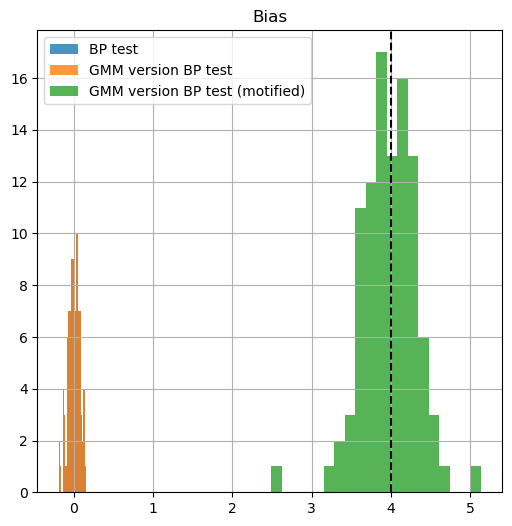

In [141]:
# visualize
fig,ax = plt.subplots(figsize=(6,6))

ax.hist(bp_draws['d'],label='BP test',bins=20,alpha=0.8)
ax.hist(bp_gmm_draws['d'],label='GMM version BP test',bins=20,alpha=0.8)
ax.hist(bp_gmm_sin_draws['d'],label='GMM version BP test (motified)',bins=20,alpha=0.8)
ax.axvline(sigma_u**2,linestyle='--',c='black')
ax.legend()
ax.grid()
ax.set_title('Bias')
plt.show()

##### (6)
Kernel regression is the method that come up in my mind under such circumstance since we don't know the form of $f$ here. However, it would be a problem to have hypothesis test with kernel regression.

## Question 4
First let's genenrate the data.

In [5]:
n = 1000
true_mu = 1
true_sigma = 2

x = iid.norm(true_mu,true_sigma).rvs(n)

##### (1)
The estimating equations would be as follows using the analogy principle,
$$
\frac{1}{N} \sum{(x_i-\mu)^m}=0\ m\ odd\\
\frac{1}{N} \sum{(x_i-\mu)^m-\sigma^m(m-1)!!}\ m\ even
$$
The parameters here are $\mu$ and $\sigma$.

In [17]:
# define the function with m is odd or even seperately
def gj_odd(mu,sigma,x,m):
    n = x.shape[0]
    e = (x-mu)**m
    return e.reshape(n,1)
def gj_even(mu,sigma,x,m):
    n = x.shape[0]
    e = (x-mu)**m-(sigma**m)*factorial2(m-1,exact=True)
    return e.reshape(n,1)

def gj(mu,sigma,x,k):
    e = gj_odd(mu,sigma,x,1)
    for m in range(2,k+1):
        em = gj_odd(mu,sigma,x,m) if m%2==1 else gj_even(mu,sigma,x,m)
        e = np.concatenate((e,em),axis=1)
    return e

##### (2)
Use the estimating equations we define in (1), we could also define the covariance matrix. Here we describe it as "Omega" since we would use it as weight in the further estimator.

In [19]:
def Omega(params,x,k,gj):
    mu = params[0]
    sigma = params[1]
    n = x.shape[0]
    
    e = gj(mu,sigma,x,k)
    # Covariance Omega hat
    Omega_hat = (e - e.mean(axis=0)).T@(e - e.mean(axis=0))/n
    return Omega_hat

##### (3) & (4)
To construct an estimator, we should also constuct a target function for the optimization process.

In [44]:
def J(params,x,k,W,gj):
    mu = params[0]
    sigma = params[1]
    n = x.shape[0]
    
    e = gj(mu,sigma,x,k)
    # J
    Jvalue = n*e.mean(axis=0).T@W@e.mean(axis=0)
    return Jvalue

To test the distribution, our method here is to use our estimated $\mu$ and $\sigma$ form a theoretical distribution, then use Kolmogorov-Smirnov test to compare our empirical distribution with theoretical distribution.

In [88]:
def norm_gmm(x,k,gj):
    # first step
    W1 = np.eye(gj(1,1,x,k).shape[1]) # identity matrix
    param_hat1 = minimize(lambda params:J(params,x,k,W1,gj),x0=[1,1]).x
    
    # second step
    W2 = np.linalg.inv(Omega(param_hat1,x,k,gj))
    res = minimize(lambda params:J(params,x,k,W2,gj),x0=[1,1])
    mu_hat = res.x[0]
    sigma_hat = res.x[1]
    J_hat = res.fun
    
    # now we try to test the null hypothesis
    n = x.shape[0]
    pvalue = 1-chi2.cdf(J_hat,k-2)
    if pvalue>0.05:
        print("It's normal distribution under {} equations".format(k))
    else:
        print("It's not normal distribution under {} equations".format(k))
    return pvalue

##### (5)
Now we try to find to optimal $k$.

In [91]:
pvalue = []

for i in range(3,23):
    pvalue.append(norm_gmm(x,i,gj))

It's normal distribution under 3 equations
It's normal distribution under 4 equations
It's normal distribution under 5 equations
It's normal distribution under 6 equations
It's normal distribution under 7 equations
It's normal distribution under 8 equations
It's not normal distribution under 9 equations
It's not normal distribution under 10 equations
It's not normal distribution under 11 equations
It's not normal distribution under 12 equations
It's not normal distribution under 13 equations
It's not normal distribution under 14 equations
It's not normal distribution under 15 equations
It's not normal distribution under 16 equations
It's not normal distribution under 17 equations
It's not normal distribution under 18 equations
It's not normal distribution under 19 equations
It's not normal distribution under 20 equations
It's not normal distribution under 21 equations
It's not normal distribution under 22 equations


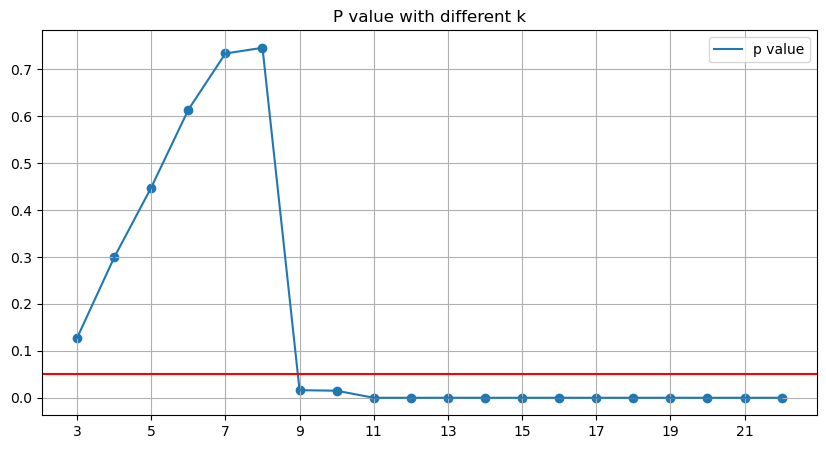

In [92]:
# plot the result
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(range(3,23),pvalue,label='p value')
ax.scatter(range(3,23),pvalue)
ax.set_xticks(range(3,23,2))
ax.axhline(0.05,c='r')
ax.grid()
ax.legend()
ax.set_title('P value with different k')
plt.show()

We could see that when $k$ goes over 8, pvalue would drop sharply and reject the true hypothesis, the reason might be that since the estimating equations with higher order might be more sensitive to the slight bias in our estimation, hence the estimated convariance in our first stage might has larger bias when $k$ increases, which cause the result of second stage has even larger bias.</br>
Since then the optimal $k$ would be 8.

##### (6)
**Difference**: For MLE, we need to assume the distribution $f$, however for GMM, we only to assume the moment condition. But for the efficient, since MLE is asymptotically approaching the Cramer-Rao Lower Bound, it could be more efficient than GMM.</br>
**Connection**: Since MLE is also a optimization problem which has $$max\ \frac{1}{N}\sum{log\ f(X_i|\mu,\sigma)}$$, we have the first order condition as $$\frac{1}{N}\sum\frac{\partial f(X_i|[\mu,\sigma])/\partial [\mu,\sigma]'}{f(X_i|[\mu,\sigma])}=0$$, it could also turn into a GMM problem.</br>


## Question 5

##### (1)
Proof:
$$
\begin{align*}
E(Y_i-\sigma(X\beta)|X)&=E(Y_i|X)-\sigma(X\beta)\\
&=Pr(Y=1|X)\times 1+Pr(Y=0|X)\times 0-\sigma(X\beta)\\
&=\sigma(X\beta)-\sigma(X\beta)=0
\end{align*}
$$
Then we could construct the estimating function as follows,
$$
E(X'(Y_i-\sigma(X\beta)))=0
$$
Then we'll have $k$ equations for $k$ paramters, which is just identified.

##### (2)
Since we know $y$ and $X$ here, then</br>
if $y_i=1$, $Pr(y_i|X_i)=\sigma(\beta'X_i)$</br>
if $y_i=0$, $Pr(y_i|X_i)=1-\sigma(\beta'X_i)$</br>
Then for all the given data, the likelihood would be
$$
\begin{align*}
L(\beta|y,X)&=\Pi Pr(y_i|X_i)^{y_i} Pr(y_i|X_i)^{1-y_i}\\
&=\Pi \sigma(\beta'X_i)^{y_i} (1-\sigma(\beta'X_i))^{1-y_i}
\end{align*}
$$